In [14]:
# Cell 1: Import libraries
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
import re
from typing import Dict, Set

# Set visualization style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (16, 12)

print("✓ All libraries imported successfully")

✓ All libraries imported successfully


In [15]:
# Cell 2: Load and explore the cyber incidents dataset
df = pd.read_csv('../data/cyber-operations-incidents.csv')

print("=" * 80)
print("DATASET EXPLORATION - Cyber Operations Incidents")
print("=" * 80)
print(f"\nDataset shape: {df.shape[0]} rows × {df.shape[1]} columns")
print(f"\nColumn names:\n{df.columns.tolist()}")
print(f"\nData types:\n{df.dtypes}")
print(f"\nMissing values (count and percentage):")
missing = df.isnull().sum()
missing_pct = (missing / len(df) * 100).round(2)
missing_df = pd.DataFrame({'Count': missing, 'Percentage': missing_pct})
print(missing_df[missing_df['Count'] > 0])

print(f"\nFirst 3 rows (sample data):")
print(df[['Title', 'Victims', 'Sponsor', 'Type', 'Category']].head(3))

print(f"\n✓ Dataset loaded successfully")

DATASET EXPLORATION - Cyber Operations Incidents

Dataset shape: 481 rows × 12 columns

Column names:
['Title', 'Date', 'Affiliations', 'Description', 'Response', 'Victims', 'Sponsor', 'Type', 'Category', 'Sources_1', 'Sources_2', 'Sources_3']

Data types:
Title           object
Date            object
Affiliations    object
Description     object
Response        object
Victims         object
Sponsor         object
Type            object
Category        object
Sources_1       object
Sources_2       object
Sources_3       object
dtype: object

Missing values (count and percentage):
              Count  Percentage
Date              7        1.46
Affiliations    134       27.86
Response        395       82.12
Victims          28        5.82
Sponsor          42        8.73
Type             34        7.07
Category         23        4.78
Sources_1         6        1.25
Sources_2       126       26.20
Sources_3       313       65.07

First 3 rows (sample data):
                                

In [16]:
# Cell 3: Clean dataset - remove records with null Victims column
print("=" * 80)
print("DATA CLEANING - Remove null Victims")
print("=" * 80)

initial_rows = len(df)
df_clean = df.dropna(subset=['Victims']).copy()
removed_rows = initial_rows - len(df_clean)

print(f"\nInitial rows: {initial_rows}")
print(f"Rows with null Victims: {removed_rows}")
print(f"Rows remaining: {len(df_clean)}")
print(f"Removal percentage: {(removed_rows / initial_rows * 100):.1f}%")

print(f"\nSample of Victims column:")
print(df_clean['Victims'].head(3).values)

print(f"\n✓ Data cleaned successfully")

DATA CLEANING - Remove null Victims

Initial rows: 481
Rows with null Victims: 28
Rows remaining: 453
Removal percentage: 5.8%

Sample of Victims column:
['Austrian Foreign Ministry' 'Employees of the U.S. government'
 'Israeli Defense Forces (IDF) soldiers']

✓ Data cleaned successfully


In [17]:
# Cell 4: AI-based state/country name normalization
# This cell implements an intelligent normalization system using pattern matching and NLP-inspired heuristics
# Maps victim/sponsor descriptions to ISO country names

# Build comprehensive country mapping database with multiple name variations
COUNTRY_MAPPING = {
    # Country names and common variations
    'Afghanistan': ['afghanistan', 'afghan'],
    'Albania': ['albania'],
    'Algeria': ['algeria', 'algerian'],
    'Argentina': ['argentina', 'argentine'],
    'Australia': ['australia', 'australian'],
    'Austria': ['austria', 'austrian'],
    'Azerbaijan': ['azerbaijan'],
    'Bahrain': ['bahrain'],
    'Bangladesh': ['bangladesh'],
    'Belarus': ['belarus', 'belarusian'],
    'Belgium': ['belgium', 'belgian'],
    'Brazil': ['brazil', 'brazilian'],
    'Bulgaria': ['bulgaria'],
    'Canada': ['canada', 'canadian'],
    'Chile': ['chile'],
    'China': ['china', 'chinese', 'wuhan', 'beijing', 'shanghai', 'hong kong', 'people republic of china', 'prc', 'people\'s republic'],
    'Colombia': ['colombia'],
    'Cyprus': ['cyprus'],
    'Czech Republic': ['czech', 'czechia'],
    'Czechia': ['czech', 'czechia'],
    'Denmark': ['denmark', 'danish'],
    'Egypt': ['egypt', 'egyptian'],
    'Estonia': ['estonia'],
    'Finland': ['finland'],
    'France': ['france', 'french'],
    'Germany': ['germany', 'german'],
    'Greece': ['greece', 'greek'],
    'Hong Kong': ['hong kong'],
    'Hungary': ['hungary', 'hungarian'],
    'Iceland': ['iceland'],
    'India': ['india', 'indian'],
    'Indonesia': ['indonesia'],
    'Iran': ['iran', 'iranian', 'islamic republic of iran'],
    'Iraq': ['iraq', 'iraqi'],
    'Ireland': ['ireland', 'irish'],
    'Israel': ['israel', 'israeli'],
    'Italy': ['italy', 'italian'],
    'Japan': ['japan', 'japanese'],
    'Jordan': ['jordan'],
    'Kazakhstan': ['kazakhstan'],
    'Kenya': ['kenya'],
    'North Korea': ['north korea', 'dprk', 'korean people'],
    'South Korea': ['south korea', 'republic of korea'],
    'Kuwait': ['kuwait'],
    'Latvia': ['latvia'],
    'Lebanon': ['lebanon'],
    'Libya': ['libya'],
    'Lithuania': ['lithuania'],
    'Luxembourg': ['luxembourg'],
    'Malaysia': ['malaysia'],
    'Mexico': ['mexico', 'mexican'],
    'Moldova': ['moldova'],
    'Monaco': ['monaco'],
    'Morocco': ['morocco'],
    'Netherlands': ['netherlands', 'dutch', 'holland'],
    'New Zealand': ['new zealand', 'nz'],
    'Nigeria': ['nigeria'],
    'Norway': ['norway'],
    'Pakistan': ['pakistan'],
    'Palestine': ['palestine', 'palestinian', 'gaza', 'west bank', 'occupied territories'],
    'Peru': ['peru'],
    'Philippines': ['philippines', 'philippine'],
    'Poland': ['poland', 'polish'],
    'Portugal': ['portugal', 'portuguese'],
    'Qatar': ['qatar'],
    'Romania': ['romania', 'romanian'],
    'Russia': ['russia', 'russian', 'soviet', 'ussr', 'russian federation', 'moscow'],
    'Saudi Arabia': ['saudi', 'saudi arabia'],
    'Singapore': ['singapore'],
    'Slovakia': ['slovakia', 'slovak'],
    'Slovenia': ['slovenia', 'slovene'],
    'South Africa': ['south africa'],
    'Spain': ['spain', 'spanish'],
    'Sweden': ['sweden', 'swedish'],
    'Switzerland': ['switzerland', 'swiss'],
    'Syria': ['syria', 'syrian', 'syrian arab republic'],
    'Taiwan': ['taiwan', 'taiwanese', 'roc'],
    'Thailand': ['thailand', 'thai'],
    'Tunisia': ['tunisia'],
    'Turkey': ['turkey', 'turkish'],
    'Ukraine': ['ukraine', 'ukrainian'],
    'Uzbekistan': ['uzbekistan'],
    'United Arab Emirates': ['emirates', 'uae', 'united arab'],
    'United Kingdom': ['united kingdom', 'uk', 'britain', 'british', 'england', 'scotland', 'wales', 'northern ireland'],
    'United States': ['united states', 'usa', 'us ', 'america', 'american', 'u.s.'],
    'Uruguay': ['uruguay'],
    'Vatican City': ['vatican', 'holy see'],
    'Vietnam': ['vietnam', 'vietnamese'],
    'Yemen': ['yemen'],
}

# Reverse mapping for faster lookups
REVERSE_MAPPING = {}
for country, aliases in COUNTRY_MAPPING.items():
    for alias in aliases:
        REVERSE_MAPPING[alias.lower()] = country

def normalize_state_name(text: str) -> str:
    """
    Normalize victim/sponsor text to ISO country name using pattern matching and heuristics.
    
    Special handling for Korea (Democratic vs Republic) and other ambiguous cases.
    """
    if pd.isna(text) or text == '':
        return "Unknown"
    
    text_lower = text.lower().strip()
    
    # Don't normalize ambiguous phrases like "Private companies in numerous countries"
    if 'numerous countries' in text_lower or 'multiple countries' in text_lower:
        return "Unknown"
    
    # PRIORITY 1: Handle Korea cases FIRST (before generic keyword matching)
    if 'korea' in text_lower:
        if 'democratic' in text_lower or 'dprk' in text_lower:
            return 'North Korea'
        elif 'republic' in text_lower:
            return 'South Korea'
    
    # PRIORITY 2: Handle other specific regional patterns
    if 'wuhan' in text_lower or 'shanghai' in text_lower or 'beijing' in text_lower:
        return 'China'
    if 'gaza' in text_lower or 'west bank' in text_lower:
        return 'Palestine'
    if 'golan' in text_lower or 'galilee' in text_lower:
        return 'Israel'
    if 'crimea' in text_lower or 'donbas' in text_lower or 'donetsk' in text_lower:
        return 'Russia'
    
    # PRIORITY 3: Keyword matching (check for matches in order of alias length)
    for alias in sorted(REVERSE_MAPPING.keys(), key=len, reverse=True):
        if alias in text_lower:
            return REVERSE_MAPPING[alias]
    
    # If still not found, return "Unknown"
    return "Unknown"

# Test the normalization function
print("=" * 80)
print("AI-BASED STATE NORMALIZATION")
print("=" * 80)

test_cases = [
    "Austrian Foreign Ministry",
    "Wuhan government, Chinese Ministry of Emergency Management",
    "Israeli Defense Forces (IDF) soldiers",
    "Employees of the U.S. government",
    "Private companies in numerous countries",
    "Russian Federation",
    "Korea (Democratic People's Republic of)",
    "Korea (Republic of)",
]

print("\nTesting normalization function:")
for test in test_cases:
    normalized = normalize_state_name(test)
    print(f"  '{test}' → '{normalized}'")

# Apply normalization to Victims and Sponsor columns
df_clean['Victims_Normalized'] = df_clean['Victims'].apply(normalize_state_name)
df_clean['Sponsor_Normalized'] = df_clean['Sponsor'].apply(normalize_state_name)

# Show statistics
print(f"\nNormalization results:")
print(f"  Victims - Unique countries: {df_clean['Victims_Normalized'].nunique()}")
print(f"  Victims - Unknown count: {(df_clean['Victims_Normalized'] == 'Unknown').sum()}")
print(f"  Sponsor - Unique countries: {df_clean['Sponsor_Normalized'].nunique()}")
print(f"  Sponsor - Unknown count: {(df_clean['Sponsor_Normalized'] == 'Unknown').sum()}")

print(f"\nTop 10 victim countries:")
print(df_clean['Victims_Normalized'].value_counts().head(10))

print(f"\nTop 10 sponsor countries:")
print(df_clean['Sponsor_Normalized'].value_counts().head(10))

print(f"\n✓ Normalization completed successfully")

AI-BASED STATE NORMALIZATION

Testing normalization function:
  'Austrian Foreign Ministry' → 'Austria'
  'Wuhan government, Chinese Ministry of Emergency Management' → 'China'
  'Israeli Defense Forces (IDF) soldiers' → 'Israel'
  'Employees of the U.S. government' → 'United States'
  'Private companies in numerous countries' → 'Unknown'
  'Russian Federation' → 'Russia'
  'Korea (Democratic People's Republic of)' → 'North Korea'
  'Korea (Republic of)' → 'South Korea'

Normalization results:
  Victims - Unique countries: 54
  Victims - Unknown count: 142
  Sponsor - Unique countries: 29
  Sponsor - Unknown count: 42

Top 10 victim countries:
Victims_Normalized
Unknown           142
United States      89
United Kingdom     42
South Korea        21
Ukraine            13
Saudi Arabia       12
Germany            10
China               9
Russia              9
India               9
Name: count, dtype: int64

Top 10 sponsor countries:
Sponsor_Normalized
China            155
Russia          

In [18]:
# Cell 4b: LLM-based fallback for Unknown countries
# Uses a local LLM (via LM Studio) to identify countries for records that failed regex normalization
import sys
import os
import time

# Add parent directory to path to import utils
sys.path.append(os.path.abspath('..'))

try:
    from utils.llm_client import get_country_from_llm
    print("✓ LLM client imported successfully")
except ImportError:
    print("⚠ Could not import utils.llm_client. Make sure the file exists.")
    # Define dummy function if import fails to prevent crash
    def get_country_from_llm(text, **kwargs): return "Unknown"

print("=" * 80)
print("LLM-BASED FALLBACK NORMALIZATION")
print("=" * 80)

# Identify records that need LLM assistance
unknown_victims = df_clean[df_clean['Victims_Normalized'] == 'Unknown']['Victims'].unique()
unknown_sponsors = df_clean[df_clean['Sponsor_Normalized'] == 'Unknown']['Sponsor'].unique()

print(f"Found {len(unknown_victims)} unique unknown victim descriptions")
print(f"Found {len(unknown_sponsors)} unique unknown sponsor descriptions")

# Combine unique texts to query
texts_to_query = set(unknown_victims) | set(unknown_sponsors)
print(f"Total unique queries to perform: {len(texts_to_query)}")

# Dictionary to cache LLM results
llm_results = {}

# Check if we should proceed (only if there are unknowns)
# We set a limit to prevent infinite loops if something goes wrong, but 1000 covers the whole dataset
MAX_QUERIES = 1000
query_count = 0

print(f"\nStarting LLM queries (Limit: {MAX_QUERIES})...")
print("Ensure LM Studio is running with server started at http://localhost:1234")

for text in texts_to_query:
    if query_count >= MAX_QUERIES:
        print(f"⚠ Reached query limit of {MAX_QUERIES}. Stopping LLM queries.")
        break
        
    if pd.isna(text) or text == '':
        continue
        
    print(f"  Querying: '{text}'...", end=" ", flush=True)
    
    # Call LLM
    llm_country = get_country_from_llm(text)
    
    if llm_country == "ConnectionError":
        print("FAILED (Connection Error)")
        print("⚠ Aborting LLM fallback. Please start LM Studio server.")
        break
        
    print(f"→ '{llm_country}'", end=" ")
    
    # Normalize the LLM output using the existing function to ensure consistency
    # e.g. LLM returns "USA" -> normalize_state_name("USA") -> "United States"
    final_country = normalize_state_name(llm_country)
    print(f"→ Normalized: '{final_country}'")
    
    llm_results[text] = final_country
    query_count += 1
    
    # Small delay to be nice to the local server
    time.sleep(0.1)

# Apply LLM results to DataFrame
print(f"\nApplying {len(llm_results)} new mappings to DataFrame...")

def apply_llm_fallback(row, col_original, col_normalized):
    if row[col_normalized] == 'Unknown':
        original_text = row[col_original]
        if original_text in llm_results:
            return llm_results[original_text]
    return row[col_normalized]

# Update Victims
df_clean['Victims_Normalized'] = df_clean.apply(
    lambda row: apply_llm_fallback(row, 'Victims', 'Victims_Normalized'), axis=1
)

# Update Sponsors
df_clean['Sponsor_Normalized'] = df_clean.apply(
    lambda row: apply_llm_fallback(row, 'Sponsor', 'Sponsor_Normalized'), axis=1
)

# Show updated statistics
print(f"\nUpdated Normalization results:")
print(f"  Victims - Unknown count: {(df_clean['Victims_Normalized'] == 'Unknown').sum()}")
print(f"  Sponsor - Unknown count: {(df_clean['Sponsor_Normalized'] == 'Unknown').sum()}")

print(f"\n✓ LLM fallback completed")

✓ LLM client imported successfully
LLM-BASED FALLBACK NORMALIZATION
Found 136 unique unknown victim descriptions
Found 5 unique unknown sponsor descriptions
Total unique queries to perform: 139

Starting LLM queries (Limit: 1000)...
Ensure LM Studio is running with server started at http://localhost:1234
  Querying: 'National Research Council'... → 'Unknown' → Normalized: 'Unknown'
  Querying: 'Uighurs'... → 'Unknown' → Normalized: 'Unknown'
  Querying: 'Uighurs'... → 'China' → Normalized: 'China'
  Querying: 'Federation Internationale de Football Association (FIFA)'... → 'China' → Normalized: 'China'
  Querying: 'Federation Internationale de Football Association (FIFA)'... → 'Unknown' → Normalized: 'Unknown'
  Querying: 'Panama'... → 'Unknown' → Normalized: 'Unknown'
  Querying: 'Panama'... → 'Panama' → Normalized: 'Unknown'
  Querying: 'Oak Ridge National Laboratory'... → 'Panama' → Normalized: 'Unknown'
  Querying: 'Oak Ridge National Laboratory'... → 'United States' → Normalized: '

In [19]:
# Cell 5: Build weighted directed graph of cyber incidents
# Graph represents attack flows: Sponsor (attacker) → Victims (targets)
# Edge weights represent the number of attacks between each country pair

print("=" * 80)
print("WEIGHTED DIRECTED GRAPH CONSTRUCTION")
print("=" * 80)

# Filter out 'Unknown' countries from graph (they represent failed normalizations)
df_graph = df_clean[
    (df_clean['Victims_Normalized'] != 'Unknown') & 
    (df_clean['Sponsor_Normalized'] != 'Unknown')
].copy()

print(f"\nRecords after filtering 'Unknown' values:")
print(f"  Original: {len(df_clean)}")
print(f"  After filter: {len(df_graph)}")
print(f"  Removed: {len(df_clean) - len(df_graph)}")

# Build edge list with aggregated weights (attack counts per country pair)
edge_df = df_graph.groupby(['Sponsor_Normalized', 'Victims_Normalized']).size().reset_index(name='weight')
edge_df.columns = ['Sponsor', 'Victims', 'weight']

# Remove self-loops (attacks from a country to itself)
edge_df_no_loops = edge_df[edge_df['Sponsor'] != edge_df['Victims']].copy()
self_loops = len(edge_df) - len(edge_df_no_loops)

print(f"\nEdge aggregation:")
print(f"  Total edges (with self-loops): {len(edge_df)}")
print(f"  Self-loops removed: {self_loops}")
print(f"  Final edges: {len(edge_df_no_loops)}")

# Create NetworkX directed graph
G = nx.DiGraph()

# Add edges with weights
for _, row in edge_df_no_loops.iterrows():
    G.add_edge(row['Sponsor'], row['Victims'], weight=row['weight'])

# Graph statistics
print(f"\nGraph statistics:")
print(f"  Nodes (countries): {G.number_of_nodes()}")
print(f"  Edges (attack routes): {G.number_of_edges()}")
print(f"  Total attacks: {sum([data['weight'] for _, _, data in G.edges(data=True)])}")
print(f"  Network density: {nx.density(G):.4f}")

# Calculate centrality metrics
in_degree = dict(G.in_degree(weight='weight'))
out_degree = dict(G.out_degree(weight='weight'))
total_degree = {node: in_degree.get(node, 0) + out_degree.get(node, 0) for node in G.nodes()}

print(f"\nTop 5 attackers (out-degree):")
sorted_attackers = sorted(out_degree.items(), key=lambda x: x[1], reverse=True)
for i, (country, degree) in enumerate(sorted_attackers[:5], 1):
    print(f"  {i}. {country}: {degree:.0f} attacks")

print(f"\nTop 5 targeted countries (in-degree):")
sorted_targets = sorted(in_degree.items(), key=lambda x: x[1], reverse=True)
for i, (country, degree) in enumerate(sorted_targets[:5], 1):
    print(f"  {i}. {country}: {degree:.0f} attacks")

# Store graph and edge data for visualization
graph_summary = {
    'nodes': G.number_of_nodes(),
    'edges': G.number_of_edges(),
    'total_attacks': sum([data['weight'] for _, _, data in G.edges(data=True)]),
}

print(f"\n✓ Graph created successfully")

WEIGHTED DIRECTED GRAPH CONSTRUCTION

Records after filtering 'Unknown' values:
  Original: 453
  After filter: 338
  Removed: 115

Edge aggregation:
  Total edges (with self-loops): 101
  Self-loops removed: 13
  Final edges: 88

Graph statistics:
  Nodes (countries): 54
  Edges (attack routes): 88
  Total attacks: 313
  Network density: 0.0307

Top 5 attackers (out-degree):
  1. China: 120 attacks
  2. Russia: 80 attacks
  3. Iran: 46 attacks
  4. North Korea: 29 attacks
  5. United States: 12 attacks

Top 5 targeted countries (in-degree):
  1. United States: 110 attacks
  2. United Kingdom: 38 attacks
  3. South Korea: 22 attacks
  4. Ukraine: 15 attacks
  5. Germany: 12 attacks

✓ Graph created successfully


GRAPH VISUALIZATION


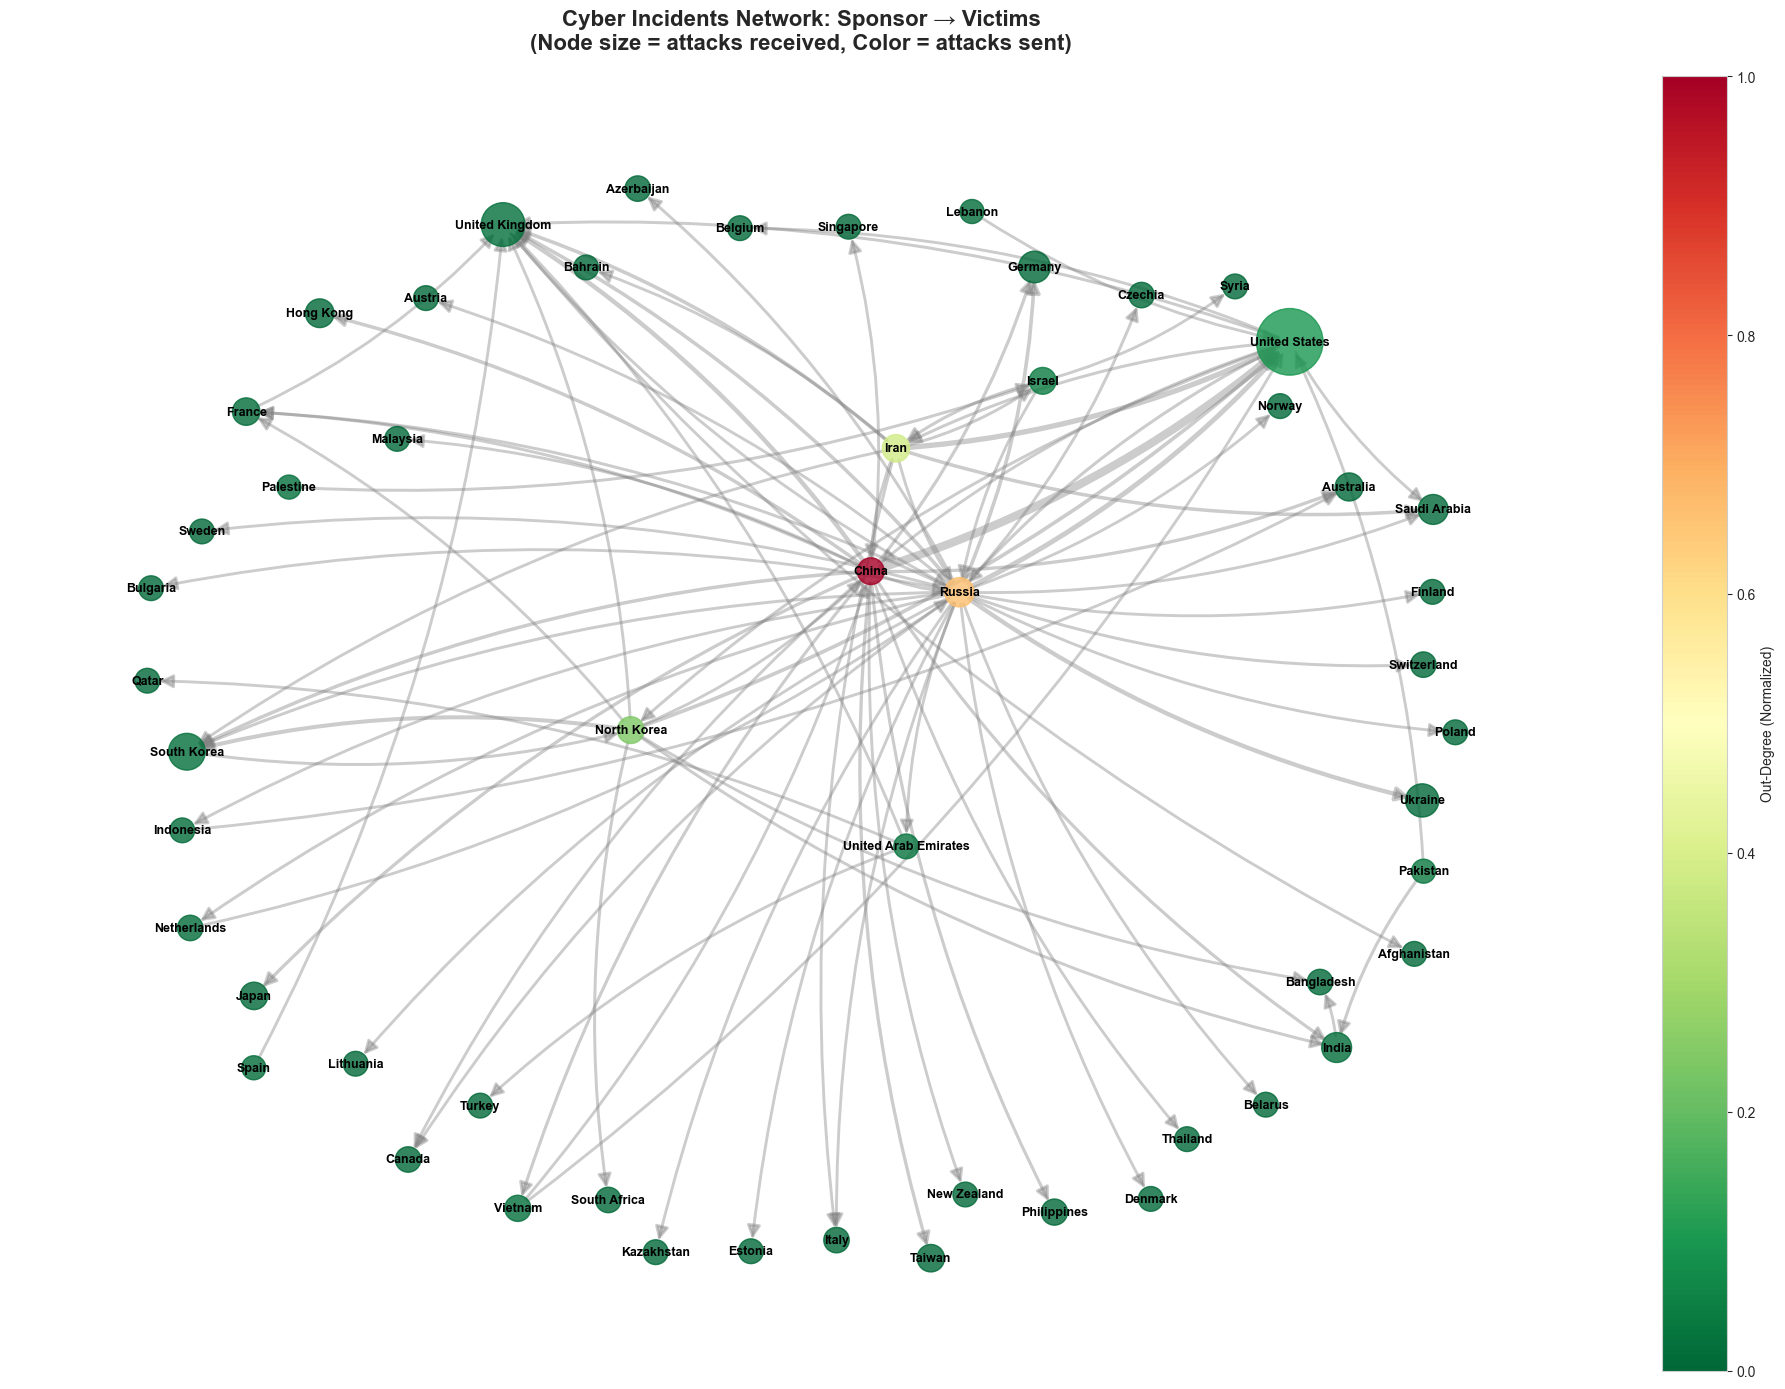

✓ Graph visualization saved to: ../data/cyber_incidents_graph_visualization.png


In [20]:
# Cell 6: Visualize the cyber incidents graph
# Create network visualization with spring layout
# Node sizes represent degree centrality
# Edge widths represent attack counts

print("=" * 80)
print("GRAPH VISUALIZATION")
print("=" * 80)

# Set fixed seed for reproducible layout
pos = nx.spring_layout(G, k=2, iterations=50, seed=42)

# Calculate node properties for visualization
in_degree_norm = {node: G.in_degree(node, weight='weight') for node in G.nodes()}
out_degree_norm = {node: G.out_degree(node, weight='weight') for node in G.nodes()}

# Normalize node sizes and colors
max_in_degree = max(in_degree_norm.values()) if in_degree_norm else 1
max_out_degree = max(out_degree_norm.values()) if out_degree_norm else 1

node_sizes = [300 + (in_degree_norm[node] / max_in_degree) * 2000 for node in G.nodes()]
node_colors = [out_degree_norm[node] / max_out_degree for node in G.nodes()]

# Extract edge properties
edges = G.edges()
weights = [G[u][v]['weight'] for u, v in edges]
max_weight = max(weights) if weights else 1
edge_widths = [2 + (w / max_weight) * 4 for w in weights]

# Create figure with high resolution
fig, ax = plt.subplots(figsize=(18, 14))

# Draw network
nx.draw_networkx_nodes(
    G, pos,
    node_size=node_sizes,
    node_color=node_colors,
    cmap=plt.cm.RdYlGn_r,
    alpha=0.8,
    ax=ax,
    vmin=0,
    vmax=1
)

nx.draw_networkx_edges(
    G, pos,
    width=edge_widths,
    edge_color='gray',
    alpha=0.4,
    ax=ax,
    connectionstyle='arc3,rad=0.1',
    arrowsize=20,
    arrowstyle='-|>',
    edge_vmin=0,
    edge_vmax=max_weight
)

nx.draw_networkx_labels(
    G, pos,
    font_size=9,
    font_weight='bold',
    ax=ax
)

# Add colorbar for node colors (out-degree)
sm = plt.cm.ScalarMappable(
    cmap=plt.cm.RdYlGn_r,
    norm=plt.Normalize(vmin=0, vmax=1)
)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax, label='Out-Degree (Normalized)', fraction=0.046, pad=0.04)

ax.set_title('Cyber Incidents Network: Sponsor → Victims\n(Node size = attacks received, Color = attacks sent)', 
             fontsize=16, fontweight='bold', pad=20)
ax.axis('off')

plt.tight_layout()
plt.savefig('../data/cyber_incidents_graph_visualization.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"✓ Graph visualization saved to: ../data/cyber_incidents_graph_visualization.png")

In [21]:
# Cell 7: Calculate centrality metrics and graph statistics
# Compute various measures of node importance in the network

print("=" * 80)
print("GRAPH ANALYSIS - CENTRALITY METRICS")
print("=" * 80)

# Calculate multiple centrality measures
print("\nCalculating centrality metrics...")

# In-degree centrality (weighted) - how many attacks a country receives
in_degree_weighted = dict(G.in_degree(weight='weight'))

# Out-degree centrality (weighted) - how many attacks a country launches
out_degree_weighted = dict(G.out_degree(weight='weight'))

# Betweenness centrality - how important a node is as a bridge in the network
try:
    betweenness = nx.betweenness_centrality(G, weight='weight')
except:
    betweenness = nx.betweenness_centrality(G)

# PageRank - importance based on incoming connections (weighted)
pagerank = nx.pagerank(G, weight='weight')

# Create centrality dataframe
centrality_df = pd.DataFrame({
    'Country': G.nodes(),
    'In_Degree': [in_degree_weighted.get(node, 0) for node in G.nodes()],
    'Out_Degree': [out_degree_weighted.get(node, 0) for node in G.nodes()],
    'Betweenness': [betweenness.get(node, 0) for node in G.nodes()],
    'PageRank': [pagerank.get(node, 0) for node in G.nodes()]
})

# Add total degree
centrality_df['Total_Degree'] = centrality_df['In_Degree'] + centrality_df['Out_Degree']

# Sort by in-degree (most targeted)
centrality_df = centrality_df.sort_values('In_Degree', ascending=False)

print(f"\nTop 10 Most Targeted Countries (In-Degree):")
print(centrality_df[['Country', 'In_Degree', 'Out_Degree', 'Total_Degree']].head(10).to_string(index=False))

print(f"\nTop 10 Most Active Attackers (Out-Degree):")
print(centrality_df.sort_values('Out_Degree', ascending=False)[['Country', 'Out_Degree', 'In_Degree', 'Total_Degree']].head(10).to_string(index=False))

print(f"\nTop 10 Bridge Nodes (Betweenness Centrality):")
print(centrality_df.sort_values('Betweenness', ascending=False)[['Country', 'Betweenness', 'In_Degree', 'Out_Degree']].head(10).to_string(index=False))

print(f"\nTop 10 by PageRank (Weighted Influence):")
print(centrality_df.sort_values('PageRank', ascending=False)[['Country', 'PageRank', 'In_Degree']].head(10).to_string(index=False))

print(f"\n✓ Centrality metrics calculated successfully")

GRAPH ANALYSIS - CENTRALITY METRICS

Calculating centrality metrics...

Top 10 Most Targeted Countries (In-Degree):
       Country  In_Degree  Out_Degree  Total_Degree
 United States        110          12           122
United Kingdom         38           2            40
   South Korea         22           2            24
       Ukraine         15           0            15
       Germany         12           0            12
         India          9           1            10
  Saudi Arabia          9           0             9
        Russia          8          80            88
     Hong Kong          7           0             7
     Australia          6           0             6

Top 10 Most Active Attackers (Out-Degree):
             Country  Out_Degree  In_Degree  Total_Degree
               China         120          4           124
              Russia          80          8            88
                Iran          46          5            51
         North Korea          29    

In [22]:
# Cell 8: Calculate and analyze community statistics
# Analyze the structure and characteristics of different attack flows

print("=" * 80)
print("COMMUNITY ANALYSIS - REGIONAL ATTACK PATTERNS")
print("=" * 80)

# Analyze edge list to find strongest relationships
print(f"\nTop 15 Strongest Attack Relationships (Sponsor → Victims):")
top_edges = edge_df_no_loops.nlargest(15, 'weight')
print(top_edges.to_string(index=False))

# Analyze attack type distribution by region
print(f"\nAttack Type Distribution (in cleaned data):")
attack_types = df_graph['Type'].value_counts()
print(attack_types.head(10))

print(f"\nTarget Category Distribution:")
target_categories = df_graph['Category'].value_counts()
print(target_categories)

# Create regional groupings for analysis
countries_in_graph = set(G.nodes())
print(f"\nParticipating countries in graph ({len(countries_in_graph)} total):")
print(sorted(countries_in_graph))

# Summary statistics
print(f"\n" + "=" * 80)
print(f"FINAL GRAPH SUMMARY")
print(f"=" * 80)
print(f"Nodes (Countries): {G.number_of_nodes()}")
print(f"Edges (Attack Relationships): {G.number_of_edges()}")
print(f"Total Incidents: {len(df_graph)}")
print(f"Total Attack Weight (aggregated): {sum([data['weight'] for _, _, data in G.edges(data=True)]):.0f}")
print(f"Average Weight per Edge: {sum([data['weight'] for _, _, data in G.edges(data=True)]) / G.number_of_edges():.2f}")
print(f"Network Density: {nx.density(G):.4f}")
print(f"Is Connected: {nx.is_weakly_connected(G)}")

print(f"\n✓ Community analysis completed successfully")

COMMUNITY ANALYSIS - REGIONAL ATTACK PATTERNS

Top 15 Strongest Attack Relationships (Sponsor → Victims):
    Sponsor        Victims  weight
      China  United States      53
       Iran  United States      24
     Russia  United States      21
      China United Kingdom      16
     Russia        Ukraine      15
North Korea    South Korea      12
North Korea  United States       9
       Iran United Kingdom       8
     Russia        Germany       8
     Russia United Kingdom       8
      China      Hong Kong       7
      China    South Korea       7
       Iran   Saudi Arabia       7
      China      Australia       5
      China          Japan       5

Attack Type Distribution (in cleaned data):
Type
Espionage            266
Sabotage              17
Denial of service     15
Data destruction       9
Defacement             5
Financial Theft        4
Doxing                 4
Name: count, dtype: int64

Target Category Distribution:
Category
Private sector                             

In [23]:
# Cell 9: Save analysis results to files
# Export graph, edge list, centrality metrics, and enriched dataset

print("=" * 80)
print("SAVING RESULTS")
print("=" * 80)

# 1. Save edge list as CSV
edge_output_path = '../data/cyber_incidents_edge_list.csv'
edge_df_no_loops.to_csv(edge_output_path, index=False)
print(f"✓ Edge list saved to: {edge_output_path}")

# 2. Save graph in GML format (compatible with Gephi)
graph_output_path = '../data/cyber_incidents_graph.gml'
nx.write_gml(G, graph_output_path)
print(f"✓ Graph saved to (GML format): {graph_output_path}")

# 3. Save centrality metrics
centrality_output_path = '../data/cyber_incidents_centrality.csv'
centrality_df.to_csv(centrality_output_path, index=False)
print(f"✓ Centrality metrics saved to: {centrality_output_path}")

# 4. Save enriched dataset with normalized countries
enriched_output_path = '../data/cyber_incidents_normalized.csv'
df_clean[['Title', 'Date', 'Victims', 'Sponsor', 'Type', 'Category', 
          'Victims_Normalized', 'Sponsor_Normalized']].to_csv(enriched_output_path, index=False)
print(f"✓ Enriched dataset saved to: {enriched_output_path}")

# 5. Save graph statistics
stats_dict = {
    'Metric': ['Number of Nodes (Countries)', 'Number of Edges (Attack Routes)', 
               'Total Incidents', 'Network Density', 'Average Degree',
               'Is Weakly Connected'],
    'Value': [G.number_of_nodes(), G.number_of_edges(), len(df_graph),
              f'{nx.density(G):.4f}', 
              f'{2 * G.number_of_edges() / G.number_of_nodes():.2f}',
              nx.is_weakly_connected(G)]
}

stats_df = pd.DataFrame(stats_dict)
stats_output_path = '../data/cyber_incidents_graph_stats.csv'
stats_df.to_csv(stats_output_path, index=False)
print(f"✓ Graph statistics saved to: {stats_output_path}")

print(f"\n" + "=" * 80)
print(f"ALL FILES SAVED SUCCESSFULLY")
print(f"=" * 80)

print(f"\nOutput files:")
print(f"  1. cyber_incidents_edge_list.csv - Edge relationships with weights")
print(f"  2. cyber_incidents_graph.gml - NetworkX graph (Gephi compatible)")
print(f"  3. cyber_incidents_centrality.csv - Centrality metrics for all countries")
print(f"  4. cyber_incidents_normalized.csv - Original data with normalized countries")
print(f"  5. cyber_incidents_graph_stats.csv - Summary statistics")
print(f"  6. cyber_incidents_graph_visualization.png - Network visualization")

print(f"\n✓ All results saved successfully")

SAVING RESULTS
✓ Edge list saved to: ../data/cyber_incidents_edge_list.csv
✓ Graph saved to (GML format): ../data/cyber_incidents_graph.gml
✓ Centrality metrics saved to: ../data/cyber_incidents_centrality.csv
✓ Enriched dataset saved to: ../data/cyber_incidents_normalized.csv
✓ Graph statistics saved to: ../data/cyber_incidents_graph_stats.csv

ALL FILES SAVED SUCCESSFULLY

Output files:
  1. cyber_incidents_edge_list.csv - Edge relationships with weights
  2. cyber_incidents_graph.gml - NetworkX graph (Gephi compatible)
  3. cyber_incidents_centrality.csv - Centrality metrics for all countries
  4. cyber_incidents_normalized.csv - Original data with normalized countries
  5. cyber_incidents_graph_stats.csv - Summary statistics
  6. cyber_incidents_graph_visualization.png - Network visualization

✓ All results saved successfully


In [24]:
# Cell 10: Final summary and validation
# Verify all results and provide comprehensive summary

print("=" * 80)
print("FINAL VALIDATION & SUMMARY")
print("=" * 80)

print(f"\nDATA PROCESSING SUMMARY:")
print(f"  Input records: {initial_rows}")
print(f"  After removing null Victims: {len(df_clean)}")
print(f"  Used for graph (non-Unknown): {len(df_graph)}")
print(f"  Records lost due to normalization: {len(df_clean) - len(df_graph)}")

print(f"\nNORMALIZATION RESULTS:")
print(f"  Victim countries: {df_clean['Victims_Normalized'].nunique()}")
print(f"  Sponsor countries: {df_clean['Sponsor_Normalized'].nunique()}")
print(f"  Total unique countries: {len(countries_in_graph)}")
print(f"  Unknown normalizations: {(df_clean['Victims_Normalized'] == 'Unknown').sum() + (df_clean['Sponsor_Normalized'] == 'Unknown').sum()}")

print(f"\nGRAPH STRUCTURE:")
print(f"  Nodes: {G.number_of_nodes()}")
print(f"  Edges: {G.number_of_edges()}")
print(f"  Self-loops removed: {self_loops}")

# For directed graphs, check weak connectivity instead
is_weakly_connected = nx.is_weakly_connected(G)
is_strongly_connected = nx.is_strongly_connected(G)
print(f"  Weakly connected: {is_weakly_connected}")
print(f"  Strongly connected: {is_strongly_connected}")

# Calculate diameter on undirected version of graph if weakly connected
if is_weakly_connected and not is_strongly_connected:
    G_undirected = G.to_undirected()
    diameter = nx.diameter(G_undirected)
    print(f"  Network diameter (undirected): {diameter}")

print(f"\nKEY INSIGHTS:")
print(f"  Most targeted country: {centrality_df.iloc[0]['Country']} ({centrality_df.iloc[0]['In_Degree']:.0f} attacks)")
most_active = centrality_df.nlargest(1, 'Out_Degree').iloc[0]
print(f"  Most active attacker: {most_active['Country']} ({most_active['Out_Degree']:.0f} attacks)")

print(f"\n✓ Analysis completed successfully!")
print(f"✓ All output files generated and saved")

FINAL VALIDATION & SUMMARY

DATA PROCESSING SUMMARY:
  Input records: 481
  After removing null Victims: 453
  Used for graph (non-Unknown): 338
  Records lost due to normalization: 115

NORMALIZATION RESULTS:
  Victim countries: 57
  Sponsor countries: 29
  Total unique countries: 54
  Unknown normalizations: 121

GRAPH STRUCTURE:
  Nodes: 54
  Edges: 88
  Self-loops removed: 13
  Weakly connected: True
  Strongly connected: False
  Network diameter (undirected): 5

KEY INSIGHTS:
  Most targeted country: United States (110 attacks)
  Most active attacker: China (120 attacks)

✓ Analysis completed successfully!
✓ All output files generated and saved


DESCRIPTIVE STATISTICS - NETWORK VISUALIZATIONS


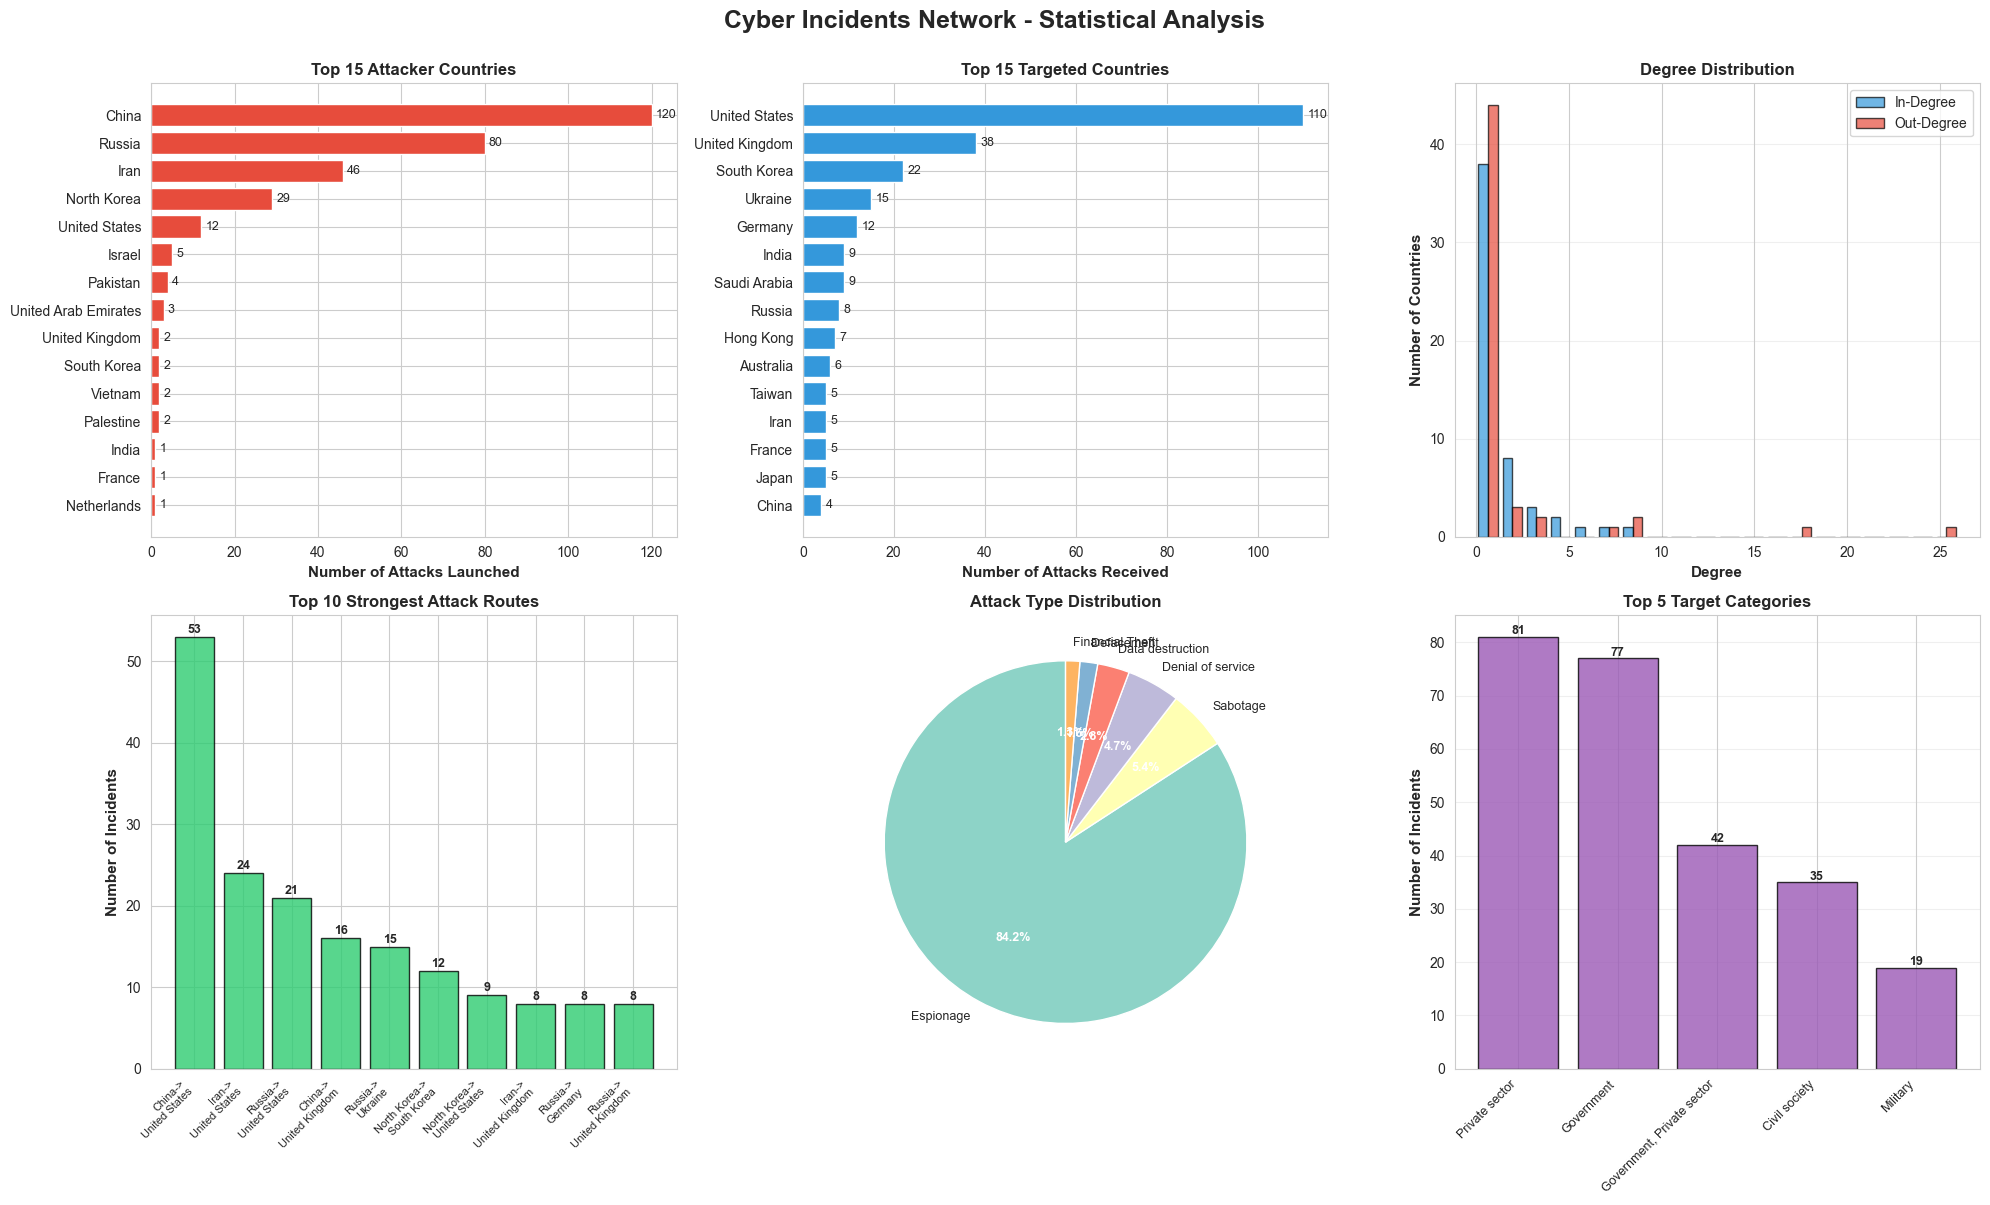

✓ Statistics visualization saved to: ../data/cyber_incidents_statistics.png


In [25]:
# Cell 11: Descriptive statistics visualizations
# Create comprehensive plots showing network characteristics

print("=" * 80)
print("DESCRIPTIVE STATISTICS - NETWORK VISUALIZATIONS")
print("=" * 80)

# Create figure with multiple subplots
fig, axes = plt.subplots(2, 3, figsize=(20, 12))
fig.suptitle('Cyber Incidents Network - Statistical Analysis', fontsize=18, fontweight='bold', y=1.00)

# 1. Top 15 Attacker Countries (Out-Degree)
ax1 = axes[0, 0]
top_attackers = centrality_df.nlargest(15, 'Out_Degree')
ax1.barh(range(len(top_attackers)), top_attackers['Out_Degree'].values, color='#e74c3c')
ax1.set_yticks(range(len(top_attackers)))
ax1.set_yticklabels(top_attackers['Country'].values)
ax1.set_xlabel('Number of Attacks Launched', fontsize=11, fontweight='bold')
ax1.set_title('Top 15 Attacker Countries', fontsize=12, fontweight='bold')
ax1.invert_yaxis()
for i, v in enumerate(top_attackers['Out_Degree'].values):
    ax1.text(v + 1, i, f'{int(v)}', va='center', fontsize=9)

# 2. Top 15 Targeted Countries (In-Degree)
ax2 = axes[0, 1]
top_targets = centrality_df.nlargest(15, 'In_Degree')
ax2.barh(range(len(top_targets)), top_targets['In_Degree'].values, color='#3498db')
ax2.set_yticks(range(len(top_targets)))
ax2.set_yticklabels(top_targets['Country'].values)
ax2.set_xlabel('Number of Attacks Received', fontsize=11, fontweight='bold')
ax2.set_title('Top 15 Targeted Countries', fontsize=12, fontweight='bold')
ax2.invert_yaxis()
for i, v in enumerate(top_targets['In_Degree'].values):
    ax2.text(v + 1, i, f'{int(v)}', va='center', fontsize=9)

# 3. Degree Distribution (both in and out)
ax3 = axes[0, 2]
degrees_in = list(dict(G.in_degree()).values())
degrees_out = list(dict(G.out_degree()).values())
ax3.hist([degrees_in, degrees_out], bins=20, label=['In-Degree', 'Out-Degree'], 
         color=['#3498db', '#e74c3c'], alpha=0.7, edgecolor='black')
ax3.set_xlabel('Degree', fontsize=11, fontweight='bold')
ax3.set_ylabel('Number of Countries', fontsize=11, fontweight='bold')
ax3.set_title('Degree Distribution', fontsize=12, fontweight='bold')
ax3.legend(fontsize=10)
ax3.grid(axis='y', alpha=0.3)

# 4. Top 10 Attack Relationships
ax4 = axes[1, 0]
top_edges_10 = edge_df_no_loops.nlargest(10, 'weight')
labels_edges = [f"{row['Sponsor']}->\n{row['Victims']}" for _, row in top_edges_10.iterrows()]
ax4.bar(range(len(top_edges_10)), top_edges_10['weight'].values, color='#2ecc71', edgecolor='black', alpha=0.8)
ax4.set_xticks(range(len(top_edges_10)))
ax4.set_xticklabels(labels_edges, rotation=45, ha='right', fontsize=8)
ax4.set_ylabel('Number of Incidents', fontsize=11, fontweight='bold')
ax4.set_title('Top 10 Strongest Attack Routes', fontsize=12, fontweight='bold')
for i, v in enumerate(top_edges_10['weight'].values):
    ax4.text(i, v + 0.5, f'{int(v)}', ha='center', fontsize=9, fontweight='bold')

# 5. Attack Type Distribution (Pie Chart)
ax5 = axes[1, 1]
attack_type_counts = df_graph['Type'].value_counts().head(6)
colors_pie = plt.cm.Set3(range(len(attack_type_counts)))
wedges, texts, autotexts = ax5.pie(attack_type_counts.values, labels=attack_type_counts.index, 
                                     autopct='%1.1f%%', colors=colors_pie, startangle=90,
                                     textprops={'fontsize': 9})
for autotext in autotexts:
    autotext.set_color('white')
    autotext.set_fontweight('bold')
ax5.set_title('Attack Type Distribution', fontsize=12, fontweight='bold')

# 6. Target Category Distribution
ax6 = axes[1, 2]
target_cat = df_graph['Category'].value_counts().head(5)
ax6.bar(range(len(target_cat)), target_cat.values, color='#9b59b6', edgecolor='black', alpha=0.8)
ax6.set_xticks(range(len(target_cat)))
ax6.set_xticklabels(target_cat.index, rotation=45, ha='right', fontsize=9)
ax6.set_ylabel('Number of Incidents', fontsize=11, fontweight='bold')
ax6.set_title('Top 5 Target Categories', fontsize=12, fontweight='bold')
ax6.grid(axis='y', alpha=0.3)
for i, v in enumerate(target_cat.values):
    ax6.text(i, v + 0.5, f'{int(v)}', ha='center', fontsize=9, fontweight='bold')

plt.tight_layout()
plt.savefig('../data/cyber_incidents_statistics.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"✓ Statistics visualization saved to: ../data/cyber_incidents_statistics.png")

CENTRALITY METRICS & NETWORK ANALYSIS VISUALIZATIONS


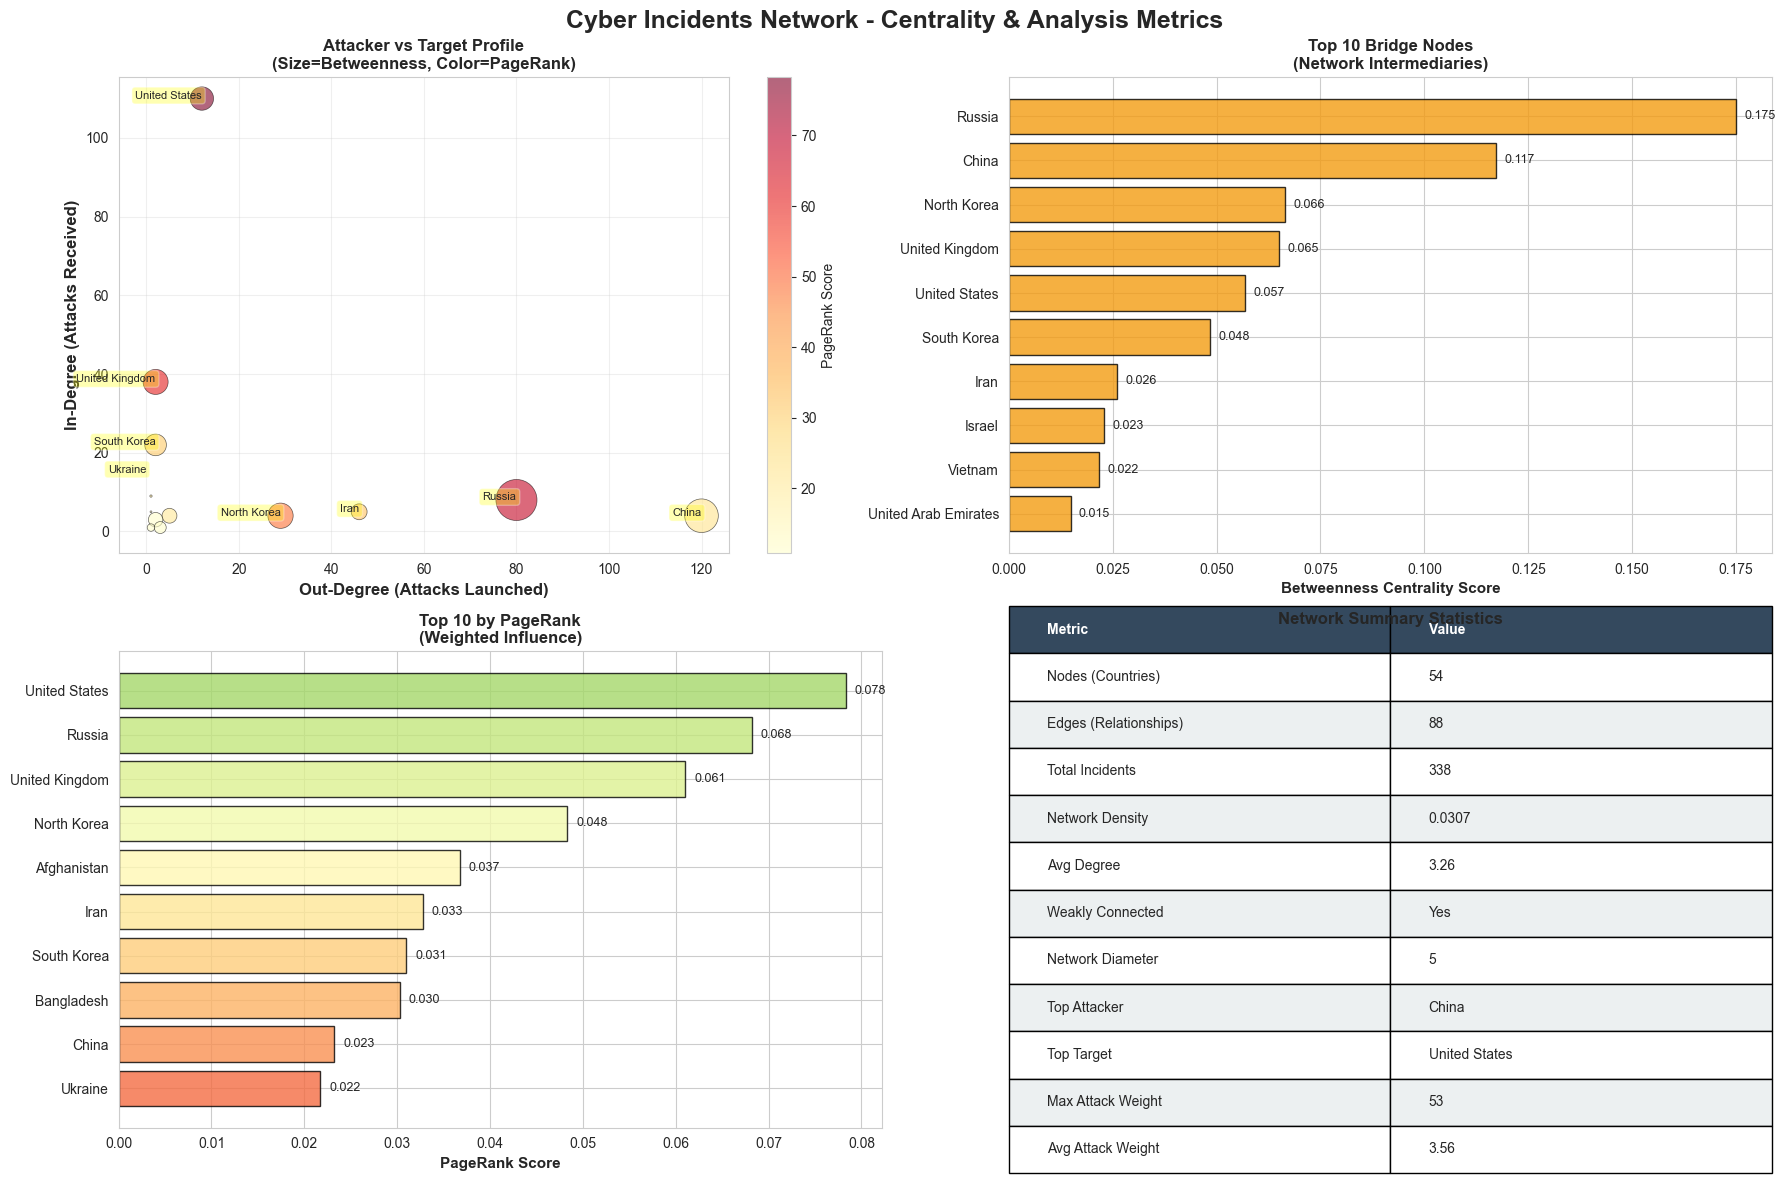

✓ Centrality analysis visualization saved to: ../data/cyber_incidents_centrality_analysis.png


In [26]:
# Cell 12: Centrality metrics and network analysis visualizations
# Advanced plots for understanding network dynamics

print("=" * 80)
print("CENTRALITY METRICS & NETWORK ANALYSIS VISUALIZATIONS")
print("=" * 80)

# Create figure with multiple analysis subplots
fig, axes = plt.subplots(2, 2, figsize=(18, 12))
fig.suptitle('Cyber Incidents Network - Centrality & Analysis Metrics', fontsize=18, fontweight='bold')

# 1. In-Degree vs Out-Degree scatter plot
ax1 = axes[0, 0]
scatter = ax1.scatter(centrality_df['Out_Degree'], centrality_df['In_Degree'], 
                      s=centrality_df['Betweenness']*5000, 
                      c=centrality_df['PageRank']*1000, 
                      cmap='YlOrRd', alpha=0.6, edgecolors='black', linewidth=0.5)

# Annotate top countries
for idx, row in centrality_df.nlargest(8, 'Total_Degree').iterrows():
    ax1.annotate(row['Country'], (row['Out_Degree'], row['In_Degree']),
                fontsize=8, ha='right', bbox=dict(boxstyle='round,pad=0.3', 
                facecolor='yellow', alpha=0.3))

ax1.set_xlabel('Out-Degree (Attacks Launched)', fontsize=12, fontweight='bold')
ax1.set_ylabel('In-Degree (Attacks Received)', fontsize=12, fontweight='bold')
ax1.set_title('Attacker vs Target Profile\n(Size=Betweenness, Color=PageRank)', 
              fontsize=12, fontweight='bold')
ax1.grid(True, alpha=0.3)
cbar1 = plt.colorbar(scatter, ax=ax1)
cbar1.set_label('PageRank Score', fontsize=10)

# 2. Betweenness Centrality Top 10
ax2 = axes[0, 1]
top_betweenness = centrality_df.nlargest(10, 'Betweenness')
ax2.barh(range(len(top_betweenness)), top_betweenness['Betweenness'].values, 
         color='#f39c12', edgecolor='black', alpha=0.8)
ax2.set_yticks(range(len(top_betweenness)))
ax2.set_yticklabels(top_betweenness['Country'].values)
ax2.set_xlabel('Betweenness Centrality Score', fontsize=11, fontweight='bold')
ax2.set_title('Top 10 Bridge Nodes\n(Network Intermediaries)', fontsize=12, fontweight='bold')
ax2.invert_yaxis()
for i, v in enumerate(top_betweenness['Betweenness'].values):
    ax2.text(v + 0.002, i, f'{v:.3f}', va='center', fontsize=9)

# 3. PageRank Top 10
ax3 = axes[1, 0]
top_pagerank = centrality_df.nlargest(10, 'PageRank')
colors_rank = plt.cm.RdYlGn_r(np.linspace(0.3, 0.8, len(top_pagerank)))
ax3.barh(range(len(top_pagerank)), top_pagerank['PageRank'].values, 
         color=colors_rank, edgecolor='black', alpha=0.8)
ax3.set_yticks(range(len(top_pagerank)))
ax3.set_yticklabels(top_pagerank['Country'].values)
ax3.set_xlabel('PageRank Score', fontsize=11, fontweight='bold')
ax3.set_title('Top 10 by PageRank\n(Weighted Influence)', fontsize=12, fontweight='bold')
ax3.invert_yaxis()
for i, v in enumerate(top_pagerank['PageRank'].values):
    ax3.text(v + 0.001, i, f'{v:.3f}', va='center', fontsize=9)

# 4. Network Metrics Summary Table
ax4 = axes[1, 1]
ax4.axis('tight')
ax4.axis('off')

# Prepare summary statistics
summary_stats = [
    ['Metric', 'Value'],
    ['Nodes (Countries)', f'{G.number_of_nodes()}'],
    ['Edges (Relationships)', f'{G.number_of_edges()}'],
    ['Total Incidents', f'{len(df_graph)}'],
    ['Network Density', f'{nx.density(G):.4f}'],
    ['Avg Degree', f'{2*G.number_of_edges()/G.number_of_nodes():.2f}'],
    ['Weakly Connected', 'Yes' if is_weakly_connected else 'No'],
    ['Network Diameter', f'{diameter}'],
    ['Top Attacker', f'{centrality_df.nlargest(1, "Out_Degree").iloc[0]["Country"]}'],
    ['Top Target', f'{centrality_df.nlargest(1, "In_Degree").iloc[0]["Country"]}'],
    ['Max Attack Weight', f'{edge_df_no_loops["weight"].max():.0f}'],
    ['Avg Attack Weight', f'{edge_df_no_loops["weight"].mean():.2f}'],
]

table = ax4.table(cellText=summary_stats, cellLoc='left', loc='center',
                 colWidths=[0.5, 0.5])
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1, 2.5)

# Style header row
for i in range(2):
    table[(0, i)].set_facecolor('#34495e')
    table[(0, i)].set_text_props(weight='bold', color='white')

# Alternate row colors
for i in range(1, len(summary_stats)):
    for j in range(2):
        if i % 2 == 0:
            table[(i, j)].set_facecolor('#ecf0f1')
        else:
            table[(i, j)].set_facecolor('#ffffff')

ax4.set_title('Network Summary Statistics', fontsize=12, fontweight='bold', pad=20)

plt.tight_layout()
plt.savefig('../data/cyber_incidents_centrality_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"✓ Centrality analysis visualization saved to: ../data/cyber_incidents_centrality_analysis.png")